# GeoPyMC Simulation Tutorial

In [1]:
import sys, os
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
import geoPyMC
import pymc as pm
import numpy as np
import geogrid
import matplotlib.pyplot as plt
reload (geoPyMC)
%matplotlib inline

Error: could not find a compiled version of noddy at C:\Users\Miguel\Anaconda\lib\site-packages\pynoddy-0.2-py2.7.egg\pynoddy\../noddy/noddy. Please ensure the source has been compiled (using GCC and compile.bat (windows) or compile.sh (unix)).
Couldn't import dot_parser, loading of dot files will not be possible.


## Initializing the Class

First we need to create the GeoPyMC_sim object providing a name for the simulation project.

In [2]:
GeoBay = geoPyMC.GeoPyMC_sim("example")

The first thing we need to do is to choose in which GeoMdel we want to perform the Bayesian inference. Making use of the next function we will assign the local path of the GeoModel that we intend to analyse.

In [3]:
GeoBay.proj_dir("C:\Users\Miguel\workspace\Thesis\Thesis\PyMC_geomod\Temp_graben")

### Set the Priors Distribution

Once we got our GeoModel, we need to provide the uncertainty distribution for the parameters that form the model. At the moment, the uncertain parameters that form our GeoModel can be given in an excel table following the format of the example. PyMC support all type of density distribution, however in pyGeoMod is only automatized for Gaussian distribution so far.

In [4]:
# Load the data from an excel. Verbose may display the table to check the correct operation
GeoBay.read_excel("C:\Users\Miguel\workspace\Thesis\Thesis\PyMC_geomod\Graben_Data_Uncert.xlsx", verbose = 0)

# Creates a PyMC object corresponding to a normal distribution of every parameter provided 
GeoBay.set_Stoch_normal_distribution()

# Now we GeoBay has the PyMC instances contact_points_mc, dips_mc and azimuths_mc encapsulating our uncertainty/priors
print GeoBay.contact_points_mc

[<pymc.distributions.Normal 'basement_right' at 0x0000000003742438>
 <pymc.distributions.Normal 'sedi1_right' at 0x000000001A0125C0>
 <pymc.distributions.Normal 'sedi2_right' at 0x000000001A012630>
 <pymc.distributions.Normal 'basement_left' at 0x000000001A0802E8>
 <pymc.distributions.Normal 'sedi1_left' at 0x000000001A0804A8>
 <pymc.distributions.Normal 'sedi2_left' at 0x000000001A080438>
 <pymc.distributions.Normal 'basement_centre' at 0x000000001A080FD0>
 <pymc.distributions.Normal 'sedi1_centre' at 0x000000001A080E80>
 <pymc.distributions.Normal 'sedi2_centre' at 0x000000001A080F60>
 <pymc.distributions.Normal 'fault_left_top' at 0x000000001A080F28>
 <pymc.distributions.Normal 'fault_left_base' at 0x000000001A080EB8>
 <pymc.distributions.Normal 'fault_right_top' at 0x000000001A080E10>
 <pymc.distributions.Normal 'fault_right_base' at 0x000000001A080B38>]


## Load the Syntetic Gravity Model

At the moment there are two ways to give the "measured gravity". Either we create a numpy array of the same dimensions as the simulation that we want to simulate or we can also give the path to a .xyz file. In the following example, we will use a forward simulation of one of our stochastic model as "measured gravity". The following code simply generates a numpy array which contain the forward simulation from a previous simulation.

In [5]:
# Loading old database
LD = pm.database.hdf5.load("C:\Users\Miguel\workspace\Thesis\Thesis\PyMC_geomod\database_paper\graben_Graben Soft Const.hdf5")

# Extracting a model from data base
Real_model = LD.trace("model", chain = 0)[-1:] 
Real_model = Real_model[0]

# Calculating gravity given the following densities
densities = {  1: 3100,
               2: 2920,
               3: 2610,
               4: 0}
Real_model.analyse_geophysics(densities)
Gravity_rm = Real_model.geophys.grv_data

# Normalizing
Gravity_rm_norm = (Gravity_rm-np.max(Gravity_rm))/np.min(Gravity_rm-np.max(Gravity_rm))

# Generating a bit of noisre
np.random.seed(25258258)
noise = np.random.normal(0,0.00011, np.shape(Gravity_rm))
Gravity_rm_noise = Gravity_rm+noise

Now we can use the GeoBay function to load the gravity data to our object, specifying ``type = "grid"`` (i.e. numpy array). Verbose allows us to plot the gravity.

Gravity Contour plot


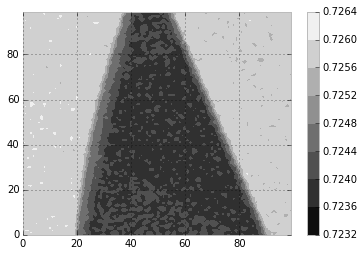

In [6]:
GeoBay.original_grav(Gravity_rm_noise, type = "grid", verbose = 1)

## Adding Constrains (Likelihood functions)

In addition to priors, our method permits the use of likelihood functions as tool to incorporate extra information and knowledge in order to constrain the model. The vast amount of possibilities make the automatization of this step extremely complex. Here, we show some examples that illustrates the flexibility and options of our method.

The creation of the GeoModel making use of the API is embeded in the method `` GeoBay.deterministic_GeoModel``. We need to give the name of the .xml f the GeoModel. This method accept multiple attributes and keywords. The most importants are the resolution of the model or if we need to calculate the forward gravity. Verbose controls a section plotting and other information that can help to assure the correct functionality of the process

In [7]:
#===============================
# First Constrains: Input data
#=============================

#============ Thickness of layers =========================

# We can create numpy arrays that contain multiple inputs. In this case we clasify our contact points according to the layer
# they belong to in order to facilitate later operations
@pm.deterministic
def sedi2(contact_points_sedi2 = GeoBay.contact_points_mc[[int(np.argwhere(GeoBay.data_depth[:,0]=="sedi2_right")),
                                                      int(np.argwhere(GeoBay.data_depth[:,0]=="sedi2_left")),
                                                      int(np.argwhere(GeoBay.data_depth[:,0]=="sedi2_centre"))]]):

    sedi2 = contact_points_sedi2
    return sedi2

@pm.deterministic
def sedi1(contact_points_sedi1 = GeoBay.contact_points_mc[[int(np.argwhere(GeoBay.data_depth[:,0]=="sedi1_right")),
                                                      int(np.argwhere(GeoBay.data_depth[:,0]=="sedi1_left")),
                                                      int(np.argwhere(GeoBay.data_depth[:,0]=="sedi1_centre"))]]):
    sedi1 = contact_points_sedi1
    return sedi1

@pm.deterministic
def basement(contact_points_basement = GeoBay.contact_points_mc[[int(np.argwhere(GeoBay.data_depth[:,0]=="basement_right")),
                                                          int(np.argwhere(GeoBay.data_depth[:,0]=="basement_left")),
                                                          int(np.argwhere(GeoBay.data_depth[:,0]=="basement_centre"))]]):
    basement =  contact_points_basement
    return basement


# Here we calculate the thickness of layers substracting the previus arrays
@pm.deterministic
def thickness_layer1(sedi1 = sedi1, sedi2 = sedi2):
    return sedi2 - sedi1

@pm.deterministic
def thickness_layer2(sedi1 = sedi1, basement = basement):
    return sedi1 - basement

# We compare the "inferred thickness" with the thickness obtained of our priors
@pm.stochastic
def thickness_layer1_likelihood(value = 150,thickness_layer1 = thickness_layer1, trace = False):
    return pm.normal_like(thickness_layer1, 180, 1./np.square(20.))

@pm.stochastic
def thickness_layer2_likelihood(value = 150,thickness_layer2 = thickness_layer2):
    return pm.normal_like(thickness_layer2, 130, 1./np.square(20.))


#================== Shape of Graben of the input data section ============================
# It is also possible to include geological knowledge. In this case, we prevent a possitive offset of our graben as well as
# a offset below our fault intersection
@pm.stochastic
def offset_negative_constraint(value = -500 ,sedi2 = sedi2):
    if sedi2[2] > sedi2[0] or sedi2[2]>sedi2[1]:
        return -np.inf
    return 0

@pm.stochastic
def offset_below_faults_constraint(value = 0,
                        fault_bases = GeoBay.contact_points_mc[[int(np.argwhere(GeoBay.data_depth[:,0]=="fault_right_base")),
                                                                int(np.argwhere(GeoBay.data_depth[:,0]=="fault_left_base"))]],
                        basement_center = GeoBay.contact_points_mc[[int(np.argwhere(GeoBay.data_depth[:,0]=="basement_centre"))]]):
    if basement_center < np.any(fault_bases)-100:
        return -np.inf
    return 0

#================= Creating the GeoModel ===================
#============================================================

# In our Bayesian Network the GeoModel behaves as a deterministic function
@pm.deterministic
def model(contact_points_val_mc = GeoBay.contact_points_mc, azimuths_val = GeoBay.azimuths_mc , dips_val = GeoBay.dips_mc):
    return  GeoBay.deterministic_GeoModel("Simple_Graben_3.xml",resolution=[100,100,10],
                                          noddy_geophy=True, densities=  {1: 3100,
                                                                           2: 2920,
                                                                           3: 2610,
                                                                           4: 0}, verbose = 0, two_points = True)





#===============================
# Second Constrains: After the model
#=============================
    #=================================
    # Inversion
    #=================================

# In the same manner as we have seen so far, gravity can be used as a constrain more
@pm.deterministic
def e_sq(grav = GeoBay.ori_grav_grid, model = model):
    Forw = model.geophys.grv_data
    e_sq = np.sum(np.square(grav - Forw))
    return e_sq


@pm.observed
def inversion(value = 1, e_sq = e_sq):
    return pm.half_cauchy_like(e_sq/0.0004,1,50.)


# PyMC request the creation of a list with all the elements that take part in the inference. The following method puts together
# priors and likelihoods ready for farther steps
GeoBay.creating_Bayes_model([sedi2,sedi1,basement, thickness_layer1, thickness_layer1_likelihood, thickness_layer2,
                      thickness_layer2_likelihood, offset_below_faults_constraint, offset_negative_constraint,
                       e_sq,inversion,  model], verbose = 0)

Once we have created the network we can generate a DOT plot to visualize it:

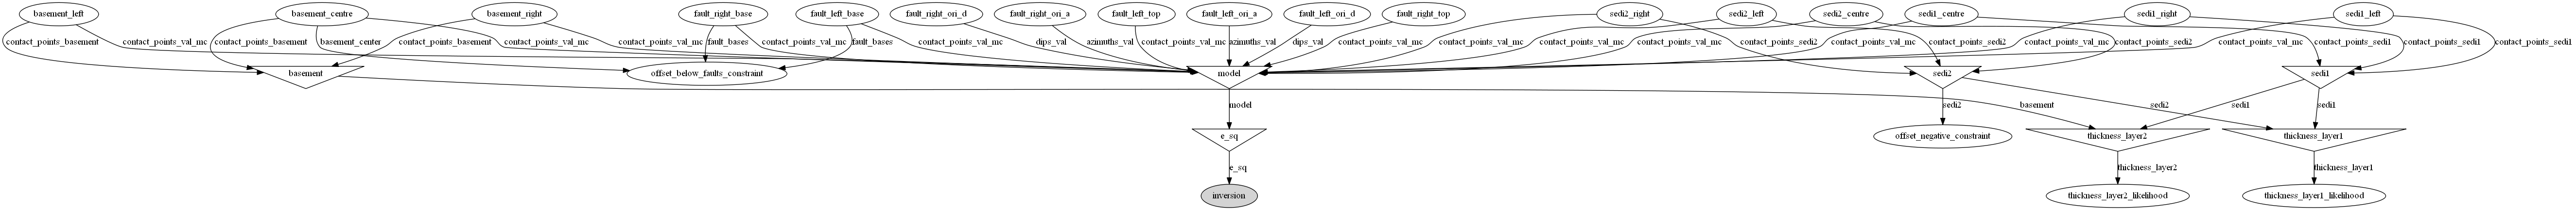

In [8]:
GeoBay.dot_plot(display = True)

#### Data base settings

Now we choose the directory where we want to save our database with our posteriors. The format used is .hdf5

In [9]:
GeoBay.MCMC_obj()

## Run Simulation

Now we can run the Bayesian inference making use of the PyMC methods as follow:

In [10]:
GeoBay.Sim_MCMC.sample(iter = 3, burn = 2)

 [-----------------------133%-----------------------] 4 of 3 complete in 307.9 sec

# Generate Posterior GeoModels from Database (Theoretical)

The database used in thsi example is not found in the repository. Please notice that the following is only a demostration how to do it.

First we load the database with our posteriors. Since the database save all the elements of the Bayesian Model we need to "forbid" all the elements that are not the input parameters of GeoModeller.

In [ ]:
# Load prior values
GeoPost = geoPyMC.GeoPyMC_GeoMod_from_posterior("5thFeb.hdf5",
                                                forbbiden = ["adaptive","model","deviance", "likelihood", "e_sq", "constrain",
        "Metropolis","layer2_conti", "order_layers", "SM2_Atley", "two_folds", "inversion", "layer2_conti" ] )


# Set directory for the new database with the GeoModels
GeoPost.proj_dir("C:\\Users\\Miguel\\Desktop\\Working_Space\\Sandstone_project\\Temp_SandstoneCopy")

In [ ]:
# Set all PyMC objects making use of the posteriors values from the database
GeoPost.recover_parameters()

# Load gravity in case file. Only necessary if dimension of the models are determined by a gravity measurement 
GeoPost.original_grav("temp\Sandstone_geophys\Sst_grav_500.xyz"
                     , type = "xyz", resolution= [85,125], verbose = 0)

We set the options of the model we want create. Notice it can be different to the model used during the Bayesian inference. This object only is used as a representation of our posteriors.

In [ ]:
@pm.deterministic(trace= True)
def model(contact_points_val_mc = GeoPost.contact_points_mc, azimuths_val = GeoPost.azimuths_mc , dips_val = GeoPost.dips_mc):
    return  GeoPost.deterministic_GeoModel("Temp_SandstoneCopy.xml",resolution=[85,125,51],
                                          noddy_geophy= True, densities=  {1: 2.61,
                                                                           2: 2.92,
                                                                           3: 3.1,
                                                                           4: 2.92,
                                                                           5: 2.61}, verbose = 0, two_points = False,
                                         plot_direction = "y", plot_cell = 42, z_dim = [-20000,1000])

GeoPost.creating_Bayes_model([model], verbose = 0)

Once we have all the PyMC objects set we can proceed  to proceed to the forward modeling step.

In [ ]:
# Defining the database name
P = pm.MCMC(GeoPost.pymc_model,  db= "hdf5" , dbname= "database_temp/5thFeb_post.hdf5")

# Run the simulation
P.sample(iter = 800)